<a href="https://colab.research.google.com/github/manuelboi/AI_project/blob/main/AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn # Contains Required functions and layers
import torch.nn.functional as F # For neural network functions:
import torch.optim as optim # Contains Optimization function available in PyTorch.
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import sys
from itertools import product
from importlib.util import find_spec

if find_spec("torchmetrics") is None:
  !pip install torchmetrics
from torchmetrics.functional import pairwise_euclidean_distance
import pickle
from urllib.request import urlopen


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
torch.Size([124800, 28, 28])
tensor([22,  6, 15,  ..., 12, 14, 18])


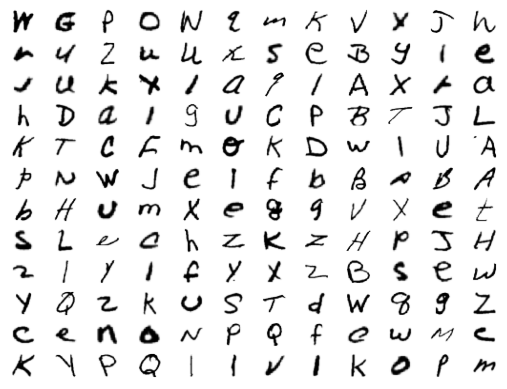

In [2]:
def show_single_letter(xi):
  xi_dim = xi.shape[0]
  vmax = torch.max(xi)

  ax = plt.gca()
  ax.grid(color='r')
  plt.xticks(range(0, xi_dim+1), fontsize=5)
  plt.yticks(range(0, xi_dim+1), fontsize=5)
  # specific values associated to "extent" attribute in order to place pixel positions precisely in the plot
  # Note: imshow plot white either if all pixels = 0 or all pixels = 255. To
  # display black when all values = 255, use vmin=0 and vmax=255
  plt.imshow(xi, extent=(0, xi_dim, xi_dim, 0), cmap='Greys', vmin=0, vmax=vmax)

def show_letters(x, n=10):
  for i in range(n**2):
    plt.subplot(n, n, i+1)
    plt.imshow(x[i], cmap="Greys")
    plt.axis("off")


DIM_IMG = 28
INPUT_SIZE = DIM_IMG ** 2
NUM_CLASSES = 26
MIN_VALUE = 0
MAX_VALUE = 255

# 124800 training set images
train_set = torchvision.datasets.EMNIST(root="data", split="letters",
                                        train=True, download=True,
                                        transform=transforms.ToTensor())

# 20800 test set images
test_set = torchvision.datasets.EMNIST(root="data", split="letters",
                                       train=False,
                                       transform=transforms.ToTensor())

# avoid to do assignment every time I execute the cell again
if "tr_images" not in globals():
  # create a tensor from a list of training samples, where each of them has been transposed and converted into a list
  # PROBLEM: not really efficient, it takes a while to execute
  tr_images = torch.tensor([image.T.tolist() for image in train_set.data])
#tr_images = train_set.data
labels = train_set.targets
for i,val in enumerate(labels):
  labels[i]=val-1

test_labels = test_set.targets
for i,val in enumerate(test_labels):
  test_labels[i]=val-1
classes = train_set.classes
print(classes)

if "test_images" not in globals():
  test_images = torch.tensor([image.T.tolist() for image in test_set.data])

show_letters(tr_images, 12)


print(tr_images.size())

dim_mask = 4

print(labels)






IF YOU WANT TO LOAD CUSTOM DATASET DIRECTLY, RUN ONLY THE CODE ABOVE, THEN RESUME EXECUTION FROM CELL "ELIA - DATASET CREATION"

Understanding tensors

In [3]:
"""print(tr_images)
print(tr_images.size())
print(tr_images[0])
print(tr_images[0].size())"""

'print(tr_images)\nprint(tr_images.size())\nprint(tr_images[0])\nprint(tr_images[0].size())'

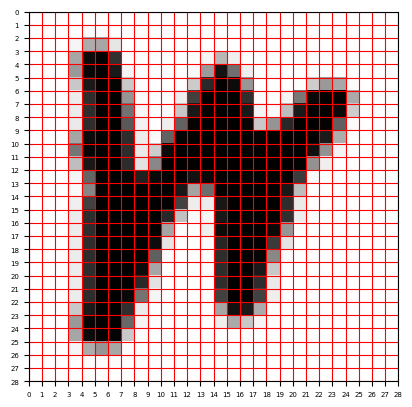

In [4]:
show_single_letter(tr_images[0])

Elia - Binarizzazione dell'immagine

In [5]:
''' UNCOMMENT TO COMPUTE AGAIN FEATURES

def binarize(image, threshold, max_value):
  return (image > threshold) * max_value

threshold = 128

tr_images_bin=torch.zeros(tr_images.size())
for i in range(tr_images.size()[0]):
  tr_images_bin[i] = binarize(tr_images[i], threshold, MAX_VALUE)

test_images_bin=torch.zeros(test_images.size())
for i in range(test_images.size()[0]):
  test_images_bin[i] = binarize(test_images[i], threshold, MAX_VALUE)

#show_letters(tr_images_bin)
show_single_letter(tr_images_bin[0])

'''


' UNCOMMENT TO COMPUTE AGAIN FEATURES\n\ndef binarize(image, threshold, max_value):\n  return (image > threshold) * max_value\n\nthreshold = 128\n\ntr_images_bin=torch.zeros(tr_images.size())\nfor i in range(tr_images.size()[0]):\n  tr_images_bin[i] = binarize(tr_images[i], threshold, MAX_VALUE)\n\ntest_images_bin=torch.zeros(test_images.size())\nfor i in range(test_images.size()[0]):\n  test_images_bin[i] = binarize(test_images[i], threshold, MAX_VALUE)\n\n#show_letters(tr_images_bin)\nshow_single_letter(tr_images_bin[0])\n\n'

Matteo: Implementazione della maschera per scheletrizzazione immagine.
Elia: Zoning density features

In [6]:
''' UNCOMMENT TO COMPUTE AGAIN FEATURES

def compute_centroid(image):
  xis, yis = np.nonzero(image.numpy())
  if xis.size or yis.size != 0:
    return int(xis.mean()), int(yis.mean())
  return None, None



# Elia
def compute_density(image):
  return torch.sum(image).item() // MAX_VALUE



def show_subimages(image):
  n_mask_positions = INPUT_SIZE / (dim_mask ** 2)
  n_plots = int(sqrt(n_mask_positions))

  # cartesian product between "range(0, DIM_IMG, dim_mask)" and "range(0, DIM_IMG, dim_mask)"
  prod_range = product(range(0, DIM_IMG, dim_mask), repeat=2)
  # enumerate assign a counter value to every combination (i, j): (0, 0) --> 1, (0, 1) --> 2, ...
  for a, (i, j) in enumerate(prod_range, start=1):
    if a > n_mask_positions:
      break

    sub_img = image[i:i+dim_mask, j:j+dim_mask]
    plt.subplot(n_plots, n_plots, a)
    show_single_letter(sub_img)



def sampling_zoning(image):

  if DIM_IMG % dim_mask != 0:
    return None, None

  centroids_abs = []
  centroids_rel = []

  # image that will be obtained from the computed centroids
  sample_img = torch.zeros(image.size())
  # be careful: at the beginning the mask moves from left to right, then from right
  # to left and so on (right to left when "i" is odd)

  prod_range = product(range(0, DIM_IMG, dim_mask), repeat=2)
  for i, j in prod_range:
      sub_img = image[i:i+dim_mask, j:j+dim_mask]
      c_ri, c_ci = compute_centroid(sub_img)

      if (c_ri, c_ci) != (None, None):
        sample_img[c_ri+i, c_ci+j] = MAX_VALUE # max_value is 255
        centroids_abs.append([c_ri+i, c_ci+j])
        centroids_rel.append([c_ri+1, c_ci+1])
      else:
        centroids_rel.append([0, 0])

  return sample_img, centroids_abs, centroids_rel


# Elia
def density_zoning(image):
  densities = []

  # image that will be obtained from the computed densities
  density_img = torch.zeros(image.size())
  # be careful: at the beginning the mask moves from left to right, then from right
  # to left and so on (right to left everytime "i" is odd)

  prod_range = product(range(0, DIM_IMG, dim_mask), repeat=2)
  for (i, j) in prod_range:
    sub_img = image[i:i+dim_mask, j:j+dim_mask]
    density = compute_density(sub_img)
    density_img[i:i+dim_mask, j:j+dim_mask] = density
    densities.append(density)

  return density_img, densities



def zoning(image, option="sampling"):
  if DIM_IMG % dim_mask != 0:
    return None, None

  if option == "density":
    density_img, densities = density_zoning(image)
    return density_img, densities

  sample_img, centroids_abs, centroids_rel = sampling_zoning(image)
  return sample_img, centroids_abs, centroids_rel




def load_sample_images(tr_images_bin):
  tr_images_cen=torch.zeros(tr_images_bin.size())
  list_cen_abs=[]
  list_cen_rel=[]
  for i in range(tr_images_bin.size()[0]):
    tr_images_cen[i], abs, rel = zoning(tr_images_bin[i])
    list_cen_abs.append(abs)
    list_cen_rel.append(rel)

  return tr_images_cen, list_cen_abs, list_cen_rel




bin_img = tr_images_bin[10]

sample_img, centroids_abs, centroids_rel = zoning(bin_img)

# If (None, None) is returned it means an error occurred in the application
# of mask and step.
if (sample_img, centroids_abs) == (None, None):
  print(f"Error: the dimension of the mask need to be a factor of {DIM_IMG}.")
  sys.exit()


print("Centroids_abs: \n", centroids_abs)
print("Centroids_rel: \n", centroids_rel)

plt.figure(1)
show_subimages(bin_img)
plt.figure(2)
plt.subplot(121)
show_single_letter(bin_img)
plt.subplot(122)
show_single_letter(sample_img)

"""# tr_sample_images is a tensor, sample_centroids is an array of list ( shape: [ [ [x, y], [x, y], ... ], [ [x, y], [x, y], ... ], ... ] )
tr_sample_images, sample_centroids = load_sample_images(tr_images_bin[0:10], dim_mask)
print(tr_sample_images.size())
print(sample_centroids) """

'''


' UNCOMMENT TO COMPUTE AGAIN FEATURES\n\ndef compute_centroid(image):\n  xis, yis = np.nonzero(image.numpy())\n  if xis.size or yis.size != 0:\n    return int(xis.mean()), int(yis.mean())\n  return None, None\n\n\n\n# Elia\ndef compute_density(image):\n  return torch.sum(image).item() // MAX_VALUE\n\n\n\ndef show_subimages(image):\n  n_mask_positions = INPUT_SIZE / (dim_mask ** 2)\n  n_plots = int(sqrt(n_mask_positions))\n\n  # cartesian product between "range(0, DIM_IMG, dim_mask)" and "range(0, DIM_IMG, dim_mask)"\n  prod_range = product(range(0, DIM_IMG, dim_mask), repeat=2)\n  # enumerate assign a counter value to every combination (i, j): (0, 0) --> 1, (0, 1) --> 2, ...\n  for a, (i, j) in enumerate(prod_range, start=1):\n    if a > n_mask_positions:\n      break\n\n    sub_img = image[i:i+dim_mask, j:j+dim_mask]\n    plt.subplot(n_plots, n_plots, a)\n    show_single_letter(sub_img)\n\n\n\ndef sampling_zoning(image):\n\n  if DIM_IMG % dim_mask != 0:\n    return None, None\n\n  cen

In [7]:
''' UNCOMMENT TO COMPUTE AGAIN FEATURES

tr_sample_images, list_centroids_abs, list_centroids_rel = load_sample_images(tr_images_bin)
ts_sample_images, ts_list_centroids_abs, ts_list_centroids_rel = load_sample_images(test_images_bin)

show_letters(tr_sample_images, 12)

'''

' UNCOMMENT TO COMPUTE AGAIN FEATURES\n\ntr_sample_images, list_centroids_abs, list_centroids_rel = load_sample_images(tr_images_bin)\nts_sample_images, ts_list_centroids_abs, ts_list_centroids_rel = load_sample_images(test_images_bin)\n\nshow_letters(tr_sample_images, 12)\n\n'

In [8]:
''' UNCOMMENT TO COMPUTE AGAIN FEATURES

# zoning with density features
density_img, densities = zoning(bin_img, option="density")

if (density_img, densities) == (None, None):
  print(f"Error: the dimension of the mask need to be a factor of {DIM_IMG}.")
  sys.exit()

plt.figure(1)
show_subimages(bin_img)
plt.figure(2)
plt.subplot(121)
show_single_letter(bin_img)
plt.subplot(122)
show_single_letter(density_img)

'''

' UNCOMMENT TO COMPUTE AGAIN FEATURES\n\n# zoning with density features\ndensity_img, densities = zoning(bin_img, option="density")\n\nif (density_img, densities) == (None, None):\n  print(f"Error: the dimension of the mask need to be a factor of {DIM_IMG}.")\n  sys.exit()\n\nplt.figure(1)\nshow_subimages(bin_img)\nplt.figure(2)\nplt.subplot(121)\nshow_single_letter(bin_img)\nplt.subplot(122)\nshow_single_letter(density_img)\n\n'

In [9]:
''' UNCOMMENT TO COMPUTE AGAIN FEATURES

def load_densities(tr_images_bin):
  tr_images_den=torch.zeros(tr_images_bin.size())
  list_densities=[]
  for i in range(tr_images_bin.size()[0]):
    tr_images_den[i], den = zoning(tr_images_bin[i], option="density")
    list_densities.append(den)

  return tr_images_den, list_densities

tr_densities, list_densities = load_densities(tr_images_bin)
ts_densities, ts_list_densities = load_densities(test_images_bin)

'''

' UNCOMMENT TO COMPUTE AGAIN FEATURES\n\ndef load_densities(tr_images_bin):\n  tr_images_den=torch.zeros(tr_images_bin.size())\n  list_densities=[]\n  for i in range(tr_images_bin.size()[0]):\n    tr_images_den[i], den = zoning(tr_images_bin[i], option="density")\n    list_densities.append(den)\n\n  return tr_images_den, list_densities\n\ntr_densities, list_densities = load_densities(tr_images_bin)\nts_densities, ts_list_densities = load_densities(test_images_bin)\n\n'

In [10]:
''' UNCOMMENT TO COMPUTE AGAIN FEATURES

show_letters(tr_densities, 12)

'''

' UNCOMMENT TO COMPUTE AGAIN FEATURES\n\nshow_letters(tr_densities, 12)\n\n'

Matteo: finding angles between pairs of centroids

In [11]:
''' UNCOMMENT TO COMPUTE AGAIN FEATURES

def angle_between(c_1, c_2, swap=False):

  # PROBLEM: WHY the condition we wish is swap = True?
  # CHECK THE CODE AGAIN

  #swap is necessary when we consider the plot of imshow
  #in imshow plot, the shown y-axis is actually the x-axis of the image, and vice versa.
  # For this reason the shape of centroid "(x, y)" in imshow plot corresponds to (y, x)
  # So you need to swap the coordinates of the parameters passed to "angle_between"

  y = torch.tensor([c_1[0, 1] - c_2[0, 1]])
  x = torch.tensor([c_1[0, 0] - c_2[0, 0]])

  if swap:
    return torch.atan2(x, y) * 180 / torch.pi
  return torch.atan2(y, x) * 180 / torch.pi


# Dictionary returned: {(c1, c2): angle_c1c2, (c1, c3): angle_c1c3, (c2, c3): angle_c3c2 ...)} <-- pairs of centroids
# it represents every segment (of the form "s = (c1, c2)"", for example) and the angle between the segment and the x axis
# PROBLEM: check again the method --> results are different than before
def rebuild_letter(sample_img):
  # "nearest subimage" concept: considering a certain subimage (same dimension of the chosen mask),
  # the nearest ones are the ones which change either the value of a row or the value of a column only,
  # and never both together, with respect to the considered subimage.

  segments = {}
  adder = dim_mask

  prod_range = product(range(0, DIM_IMG, dim_mask), repeat=2)
  for i, j in prod_range:
      new_i = i + dim_mask
      new_j = j + dim_mask
      sub_img = sample_img[i:new_i, j:new_j]

      # extract centroid coordinates from sub_img
      curr_cent = torch.nonzero(sub_img)
      # check if the tensor is not "empty"
      if torch.numel(curr_cent) != 0:
        # now current centroid refers to the actual one, considering the current i and j in sample image
        curr_cent = torch.tensor([curr_cent[0, 0].item() + i,
                                  curr_cent[0, 1].item() + j]).reshape(1, 2)

        # finding all the nearest subimages:
        # z = 0: adder = dim_mask, new_i considered; z = 1: adder = -dim_mask, new_i considered;
        # z = 2: adder = dim_mask, new_j considered; z = 3: adder = -dim_mask, new_j considered
        # neighbours for the centroid being analyzed
        for z in range(4):
          if z >= 2:
            pair_i = [i, new_i]
            pair_j = [j+adder, new_j+adder]
            pair_cond = pair_j
          else:
            pair_i = [i+adder, new_i+adder]
            pair_j = [j, new_j]
            pair_cond = pair_i

          neigh_subimg = torch.tensor([])
          neigh_cent = torch.tensor([])

          if (0 <= pair_cond[0] <= DIM_IMG - 1) and (0 <= pair_cond[1] <= DIM_IMG - 1):
            neigh_subimg = sample_img[pair_i[0]:pair_i[1], pair_j[0]:pair_j[1]]
            neigh_cent = torch.nonzero(neigh_subimg)
            if torch.numel(neigh_cent) != 0:
              neigh_cent = torch.tensor([neigh_cent[0, 0].item() + pair_i[0],
                                         neigh_cent[0, 1].item() + pair_j[0]]).reshape(1, 2)

          # neigh_cent empty --> no centroid found in that neighbour sub_img
          if torch.numel(neigh_cent) != 0:
            curr_cent_tpl = (curr_cent[0, 0].item(), curr_cent[0, 1].item())
            neigh_cent_tpl = (neigh_cent[0, 0].item(), neigh_cent[0, 1].item())

            if (curr_cent_tpl, neigh_cent_tpl) not in segments and (neigh_cent_tpl, curr_cent_tpl) not in segments:
              if pairwise_euclidean_distance(curr_cent, neigh_cent) < dim_mask + 1:
                angle = angle_between(curr_cent, neigh_cent, True).item()
                segments[(curr_cent_tpl, neigh_cent_tpl)] = angle

          adder = -(adder)

  return segments



def show_letter_from_segments(segments):
  # It shows the "rebuilt" letter starting from segments and angles found
  x1 = []
  x2 = []
  y1 = []
  y2 = []

  for couple_cents in segments:
    x1.append(couple_cents[0][1])
    y1.append(couple_cents[0][0])
    x2.append(couple_cents[1][1])
    y2.append(couple_cents[1][0])

  # ARRAY X: [[12, 16, 18, 11], [16, 18, 15, 15]]
  # ARRAY Y: [[4, 4, 10, 10], [4, 10, 14, 14]]
  # (12, 4) connects to (16,4), (16,4) to (18,10), (18,10) to (15,14)...
  x = np.array([x1, x2])
  y = np.array([y1, y2])

  print("Y:", y)
  print("X:", x)

  plt.plot(x, y, "-o")
  plt.axis([0, 28, 28, 0])
  for i in range(y.shape[1]):
    plt.annotate(f"{i+1}", (x[0, i], y[0, i]))

  plt.xticks(range(0, 29))
  plt.yticks(range(0, 29))
  ax = plt.gca()
  ax.grid(color='r')
  plt.show()




sample_img, centroids, _ = zoning(bin_img)

segments = rebuild_letter(sample_img)

# Calculate list of all segments for each sample
segments_list = []
for i in range(tr_sample_images.size()[0]):
  segments_list.append(rebuild_letter(tr_sample_images[i]))
ts_segments_list = []
for i in range(ts_sample_images.size()[0]):
  ts_segments_list.append(rebuild_letter(ts_sample_images[i]))

plt.figure(2)
plt.subplot(121)
show_single_letter(bin_img)
plt.subplot(122)
show_single_letter(sample_img)

plt.figure(3)
show_letter_from_segments(segments)

'''

' UNCOMMENT TO COMPUTE AGAIN FEATURES\n\ndef angle_between(c_1, c_2, swap=False):\n\n  # PROBLEM: WHY the condition we wish is swap = True?\n  # CHECK THE CODE AGAIN\n\n  #swap is necessary when we consider the plot of imshow\n  #in imshow plot, the shown y-axis is actually the x-axis of the image, and vice versa.\n  # For this reason the shape of centroid "(x, y)" in imshow plot corresponds to (y, x)\n  # So you need to swap the coordinates of the parameters passed to "angle_between"\n\n  y = torch.tensor([c_1[0, 1] - c_2[0, 1]])\n  x = torch.tensor([c_1[0, 0] - c_2[0, 0]])\n\n  if swap:\n    return torch.atan2(x, y) * 180 / torch.pi\n  return torch.atan2(y, x) * 180 / torch.pi\n\n\n# Dictionary returned: {(c1, c2): angle_c1c2, (c1, c3): angle_c1c3, (c2, c3): angle_c3c2 ...)} <-- pairs of centroids\n# it represents every segment (of the form "s = (c1, c2)"", for example) and the angle between the segment and the x axis\n# PROBLEM: check again the method --> results are different than 

Manuel - Approssimazione dell'angolo nelle 4 direzioni

In [12]:
''' UNCOMMENT TO COMPUTE AGAIN FEATURES

from enum import Enum

class Direction(Enum):
  HORIZONTAL = 1
  RIGHT_INCLINED = 2
  VERTICAL = 3
  LEFT_INCLINED = 4

  def __sub__(self, other):
    return int(self) - other

  def __div__(self, other):
    return int(self) / other

def approximate_angle(angle):
  if (angle > -22.5 and angle <= 22.5) or (angle > 157.5 and angle >= -157.5):
    approximation = Direction.HORIZONTAL
  elif (angle > 22.5 and angle <= 67.5) or (angle > -157.5 and angle <= -112.5):
    approximation = Direction.RIGHT_INCLINED
  elif (angle > 67.5 and angle <= 112.5) or (angle > -112.5 and angle <= -67.5):
    approximation = Direction.VERTICAL
  else:
    approximation = Direction.LEFT_INCLINED

  return approximation

def load_inclinations(segments_list):
  list_inclinations = []
  for sample in segments_list:
    counts = [0, 0, 0, 0]
    for segment in sample:
      dictionary_value = sample[segment]
      direction = (approximate_angle(dictionary_value))
      if direction == Direction.HORIZONTAL:
        counts[0] += 1
      elif direction == Direction.RIGHT_INCLINED:
        counts[1] += 1
      elif direction == Direction.VERTICAL:
        counts[2] += 1
      else:
        counts[3] += 1
      list_inclinations.append(counts)
  return list_inclinations




list_inclinations = load_inclinations(segments_list)
ts_list_inclinations = load_inclinations(ts_segments_list)

'''


' UNCOMMENT TO COMPUTE AGAIN FEATURES\n\nfrom enum import Enum\n\nclass Direction(Enum):\n  HORIZONTAL = 1\n  RIGHT_INCLINED = 2\n  VERTICAL = 3\n  LEFT_INCLINED = 4\n\n  def __sub__(self, other):\n    return int(self) - other\n\n  def __div__(self, other):\n    return int(self) / other\n\ndef approximate_angle(angle):\n  if (angle > -22.5 and angle <= 22.5) or (angle > 157.5 and angle >= -157.5):\n    approximation = Direction.HORIZONTAL\n  elif (angle > 22.5 and angle <= 67.5) or (angle > -157.5 and angle <= -112.5):\n    approximation = Direction.RIGHT_INCLINED\n  elif (angle > 67.5 and angle <= 112.5) or (angle > -112.5 and angle <= -67.5):\n    approximation = Direction.VERTICAL\n  else:\n    approximation = Direction.LEFT_INCLINED\n\n  return approximation\n\ndef load_inclinations(segments_list):\n  list_inclinations = []\n  for sample in segments_list:\n    counts = [0, 0, 0, 0]\n    for segment in sample:\n      dictionary_value = sample[segment]\n      direction = (approximate

Elia - Dataset creation

In [13]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, features, labels):
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

Manuel - Rete neurale

In [14]:
class NeuralNetwork(nn.Module):


  def __init__(self, n_input, n_output):
    super().__init__()
    self.n_input = n_input
    self.n_output = n_output
    self.mid_n = int((n_input + n_output) / 2)

    # Define Layers:
    self.l1 = nn.Linear(self.n_input, self.mid_n) # layer 1
    self.l2 = nn.Linear(self.mid_n, self.n_output) # layer 2
    self.l3 = nn.Linear(self.n_output, self.n_output) # layer 3

    # Define Activation functions:
    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim = 1)

    # Weights initialization
    nn.init.kaiming_normal_(self.l1.weight, mode='fan_in', nonlinearity='relu') # Using HE because more optimized for ReLU activated layers
    nn.init.zeros_(self.l1.bias)
    nn.init.kaiming_normal_(self.l2.weight, mode='fan_in', nonlinearity='relu')
    nn.init.zeros_(self.l2.bias)
    nn.init.normal_(self.l3.weight) # Using normal distribution for LogSoftMax activated layer
    nn.init.normal_(self.l3.bias)


  def forward(self, x):
    '''
    Layers: 3
    Activation Functions:
    RELU for first two layers
    Log Softmax for last layer
    '''
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    x = self.l3(x)
    x = self.softmax(x)
    return x

  def train_model(self, tr_loader, n_epochs, criterion, optimizer):
    # losses --> {[*idx_first_epoch*]: loss_1, [*idx_second_epoch*]: loss_2, ...}
    losses = {}
    for e in range(n_epochs):
      for features, labels in tr_loader:
        optimizer.zero_grad() # set optimizer gradients to zero:
        output = self(features) # Intial output
        loss = criterion(output, labels.long()) # Loss Caluclation
        loss.backward() # Pass loss function gradients to pervious layers:
        optimizer.step() # Update Weights
        losses[e] = loss.item()

    return losses


  def test_model(self, ts_loader):
    correct = 0
    total = 0
    for features, labels in ts_loader:
      outputs = self(features)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum()

    return correct / total



# Define macros.
number_of_features = 151 # 49 x coordinates of the centroid, 49 y coordinates of the centroid, 49 density values, 4 number of inclinations.
number_of_outputs = 26 # Output letters of the alphabet.


n_NNs = 10
list_NNs = []
list_criterions = []
list_optimizers = []
for i in range(n_NNs):
  list_NNs.append(NeuralNetwork(number_of_features, number_of_outputs))
  list_criterions.append(nn.NLLLoss())
  list_optimizers.append(optim.Adam(list_NNs[i].parameters(), lr=0.001))

'''
# Intialize NN, loss function and optimizer
NN = NeuralNetwork(number_of_features, number_of_outputs)
criterion = nn.NLLLoss()
optimizer = optim.Adam(NN.parameters(), lr = 0.001)
'''

'\n# Intialize NN, loss function and optimizer\nNN = NeuralNetwork(number_of_features, number_of_outputs)\ncriterion = nn.NLLLoss()\noptimizer = optim.Adam(NN.parameters(), lr = 0.001)\n'

Manuel - Dataset Creation

In [15]:
# General purpose functions

def normalize(value, min, max):
  return (value - min) / (max - min)


def create_dataset(n_samples, images_centroids, density_values, n_inclinations):
  dataset_list = []
  for i in range(len(images_centroids)):
    list_tmp = []
    for centroid in images_centroids[i]:
        list_tmp.append(normalize(centroid[0], min_x_coordinates, max_x_coordinates))
        list_tmp.append(normalize(centroid[1], min_y_coordinates, max_y_coordinates))

    for density in density_values[i]:
      list_tmp.append(normalize(density, min_density_value, max_density_value))

    for n_inclination in n_inclinations[i]:
      list_tmp.append(normalize(n_inclination, min_n_inclinations, max_n_inclinations))

    dataset_list.append(list_tmp)

  return torch.tensor(dataset_list)


# Define min and max for each feature. If there is no centroid, coordinates x and y are 0.
min_x_coordinates = 0
max_x_coordinates = 4
min_y_coordinates = 0
max_y_coordinates = 4
min_density_value = 0
max_density_value = 16
min_n_inclinations = 0
max_n_inclinations = 84


""" TO LOAD CUSTOM DATASET DIRECTLY, COMMENT THE CODE BELOW """
""" START OF COMMENTS """
'''
# set CPU or GPU, if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Prepare dataset
features = create_dataset(len(list_centroids_rel), list_centroids_rel, list_densities, list_inclinations)
test_features = create_dataset(len(ts_list_centroids_rel), ts_list_centroids_rel, ts_list_densities, ts_list_inclinations)

trainset = CustomDataset(features, labels)


testset = CustomDataset(test_features, test_labels)
'''
""" END OF COMMENTS """


' END OF COMMENTS '

In [16]:

def read_dataset(url):
  dataset = pickle.load(urlopen(url))
  return dataset


trainset = read_dataset("https://github.com/manuelboi/AI_project/raw/main/training_dataset.pt")
testset = read_dataset("https://github.com/manuelboi/AI_project/raw/main/testing_dataset.pt")

print(trainset.features.size())
print(testset.features.size())



torch.Size([124800, 151])
torch.Size([20800, 151])


In [17]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # trainloader is what holds the data loader object which takes care of shuffling the data and constructing the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False) # No need to shuffle test data.

Manuel - Model training

In [18]:
mean_accuracy = 0

# Train the model
for i in range(n_NNs):
  dct_losses = list_NNs[i].train_model(trainloader, 5, list_criterions[i], list_optimizers[i])
  print(dct_losses)

# Test the model
for i in range(n_NNs):
  accuracy = list_NNs[i].test_model(testloader)
  mean_accuracy += accuracy
  print(f"Accuracy of the model on the test images: {accuracy * 100} %")

mean_accuracy /= n_NNs

{0: 1.0701950788497925, 1: 0.8103930354118347, 2: 0.5184479355812073, 3: 0.38383013010025024, 4: 0.5672407746315002}
{0: 0.8389561176300049, 1: 0.9679270386695862, 2: 0.7588090300559998, 3: 0.6539801955223083, 4: 0.8670266270637512}
{0: 0.7637755870819092, 1: 0.7024797797203064, 2: 0.49145644903182983, 3: 0.5169264674186707, 4: 0.435703307390213}
{0: 0.7842028737068176, 1: 0.47770747542381287, 2: 0.6446706652641296, 3: 0.6400330662727356, 4: 0.37688401341438293}
{0: 0.8448801636695862, 1: 0.49912312626838684, 2: 0.3879362940788269, 3: 0.42555272579193115, 4: 0.21049362421035767}
{0: 0.7127099633216858, 1: 0.46869009733200073, 2: 0.5701798796653748, 3: 0.6934344172477722, 4: 0.20869746804237366}
{0: 0.8812951445579529, 1: 0.5359601378440857, 2: 0.45598506927490234, 3: 0.6142933368682861, 4: 0.4143848419189453}
{0: 0.8165957927703857, 1: 0.5431325435638428, 2: 0.7034426927566528, 3: 0.5275943279266357, 4: 0.6055855751037598}
{0: 1.1646147966384888, 1: 0.4369758069515228, 2: 0.68526887893

Matteo - Tests on accuracy with different quantities of training samples


Number of training samples:  2600
Loss at epoch 0: 3.0555567741394043
Loss at epoch 1: 2.944136142730713
Loss at epoch 2: 2.760929822921753
Loss at epoch 3: 2.2232842445373535
Loss at epoch 4: 2.1154820919036865
Accuracy: 40.841346740722656 %

Number of training samples:  8450
Loss at epoch 0: 1.9750804901123047
Loss at epoch 1: 1.2841360569000244
Loss at epoch 2: 2.96400785446167
Loss at epoch 3: 1.596847653388977
Loss at epoch 4: 0.38710451126098633
Accuracy: 63.1009635925293 %

Number of training samples:  14300
Loss at epoch 0: 2.168883800506592
Loss at epoch 1: 1.374014973640442
Loss at epoch 2: 1.0508058071136475
Loss at epoch 3: 1.3273216485977173
Loss at epoch 4: 0.640932559967041
Accuracy: 70.15384674072266 %

Number of training samples:  26000
Loss at epoch 0: 2.7554640769958496
Loss at epoch 1: 0.8546547889709473
Loss at epoch 2: 0.8986347913742065
Loss at epoch 3: 1.2250018119812012
Loss at epoch 4: 1.1338626146316528
Accuracy: 75.13941955566406 %

Number of training sampl

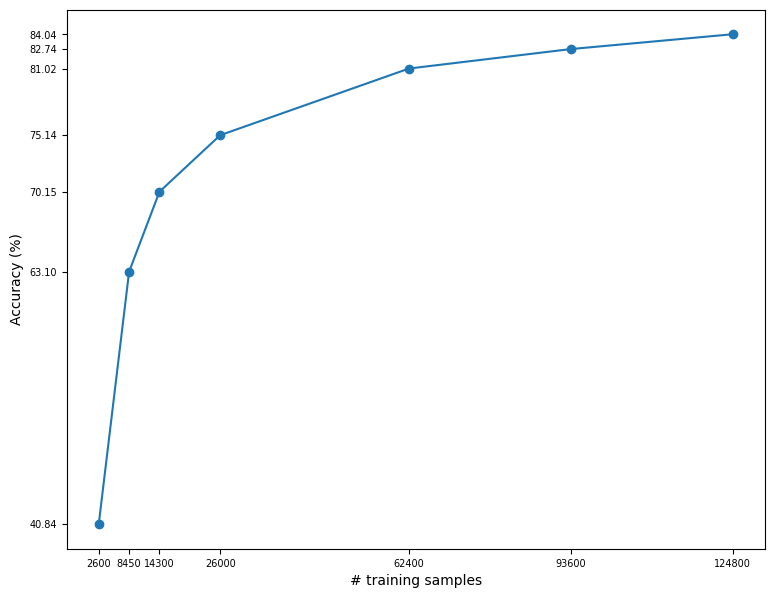

In [19]:
def get_balanced_dataset(n, trainset):
  """
   It takes n training samples for each letter and returns
   a balanced dataset
  """

  samples = trainset.features
  labels = trainset.labels

  new_features = torch.tensor([])
  new_labels = torch.tensor([])

  # iterating over all the letters
  for idx in range(NUM_CLASSES):
    samples_from_letter = samples[labels==idx, :]
    new_features = torch.cat((new_features, samples_from_letter[:n, :]))
    new_labels = torch.cat((new_labels, torch.tensor([idx]*n)))

  return CustomDataset(new_features, new_labels)





list_NNs = []
list_criterions = []
list_optimizers = []
lst_accuracies = []
lst_n_samples = [2600, 8450, 14300, 26000, 62400, 93600]

for i, n_samples_i in enumerate(lst_n_samples):
  print("\nNumber of training samples: ", n_samples_i)

  list_NNs.append(NeuralNetwork(number_of_features, number_of_outputs))
  list_criterions.append(nn.NLLLoss())
  list_optimizers.append(optim.Adam(list_NNs[i].parameters(), lr=0.001))

  trainset_i = get_balanced_dataset(n_samples_i // number_of_outputs, trainset)
  trainloader_i = torch.utils.data.DataLoader(trainset_i, batch_size=64, shuffle=True)

  # train model i
  dct_losses = list_NNs[i].train_model(trainloader_i, 5, list_criterions[i], list_optimizers[i])
  for epoch_i in dct_losses:
    print(f"Loss at epoch {epoch_i}: {dct_losses[epoch_i]}")


  #test model i
  accuracy = list_NNs[i].test_model(testloader)
  lst_accuracies.append(accuracy * 100)
  print(f"Accuracy: {lst_accuracies[i]} %")

lst_n_samples.append(124800)
lst_accuracies.append(mean_accuracy * 100)

# Graph of accuracies against number of training samples

plt.figure(figsize=(9, 7))
plt.plot(lst_n_samples, lst_accuracies, "o-")
plt.xticks(lst_n_samples, fontsize=7)
plt.yticks(lst_accuracies, fontsize=7)
plt.xlabel('# training samples')
plt.ylabel('Accuracy (%)')
plt.show()


In [20]:
#In order to get the features desired, it is sufficient to slice appropriately the trainset and the testset


features_train_centroids = trainset.features[:, :98]
features_train_densities = trainset.features[:, 98:147]
features_train_inclinations = trainset.features[:, 147:]
features_train_centroids_densities = trainset.features[:, :147]
features_train_centroids_inclinations = torch.cat((features_train_centroids, features_train_inclinations), dim=1)
features_train_densities_inclinations = trainset.features[:, 98:]

features_train = [features_train_centroids, features_train_densities, features_train_inclinations, features_train_centroids_densities,
                features_train_centroids_inclinations, features_train_densities_inclinations]

features_test_centroids = testset.features[:, :98]
features_test_densities = testset.features[:, 98:147]
features_test_inclinations = testset.features[:, 147:]
features_test_centroids_densities = testset.features[:, :147]
features_test_centroids_inclinations = torch.cat((features_test_centroids, features_test_inclinations), dim=1)
features_test_densities_inclinations = testset.features[:, 98:]

features_test = [features_test_centroids, features_test_densities, features_test_inclinations, features_test_centroids_densities,
                features_test_centroids_inclinations, features_test_densities_inclinations]



# Creation of a list of neural networks for ceach combination of features
v_num_features = [98, 49, 4, 147, 102, 53]
number_of_outputs = 26
list_NNs = []
list_criterions = []
list_optimizers = []
for i in range(len(v_num_features)):
  list_NNs.append(NeuralNetwork(v_num_features[i], number_of_outputs))
  list_criterions.append(nn.NLLLoss())
  list_optimizers.append(optim.Adam(list_NNs[i].parameters(), lr=0.001))

for i in range(len(v_num_features)):
  """features = features_train[i]
  trainset = CustomDataset(features, trainset.labels)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
  test_features = features_test[i]
  testset = CustomDataset(test_features, testset.labels)
  testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)"""

  new_trainset = CustomDataset(features_train[i], trainset.labels)
  new_trainloader = torch.utils.data.DataLoader(new_trainset, batch_size=64, shuffle=True)

  new_testset = CustomDataset(features_test[i], testset.labels)
  new_testloader = torch.utils.data.DataLoader(new_testset, batch_size=64, shuffle=False)

  #Training phase
  dct_losses = list_NNs[i].train_model(new_trainloader, 5, list_criterions[i], list_optimizers[i])
  print("Losses for NN {} {}".format(i, dct_losses))

  # Test phase
  accuracy = list_NNs[i].test_model(new_testloader)
  print(f"Accuracy of the model {i} on the test images: {accuracy * 100} %")

Losses for NN 0 {0: 1.0979865789413452, 1: 1.0911298990249634, 2: 1.0555174350738525, 3: 0.7041710019111633, 4: 0.6782130599021912}
Accuracy of the model 0 on the test images: 75.13941955566406 %
Losses for NN 1 {0: 1.1301982402801514, 1: 0.5662131905555725, 2: 0.6781518459320068, 3: 0.5916998386383057, 4: 0.6376438736915588}
Accuracy of the model 1 on the test images: 78.77404022216797 %
Losses for NN 2 {0: 3.2636115550994873, 1: 3.2574846744537354, 2: 3.26901912689209, 3: 3.269174575805664, 4: 3.2546873092651367}
Accuracy of the model 2 on the test images: 3.5 %
Losses for NN 3 {0: 0.6559720635414124, 1: 0.7297656536102295, 2: 0.7045285105705261, 3: 0.613972008228302, 4: 0.4791032075881958}
Accuracy of the model 3 on the test images: 83.90384674072266 %
Losses for NN 4 {0: 1.031287670135498, 1: 0.9815816879272461, 2: 1.1018391847610474, 3: 0.625676691532135, 4: 1.1001056432724}
Accuracy of the model 4 on the test images: 74.83654022216797 %
Losses for NN 5 {0: 1.3516027927398682, 1: 